## Дисперсионный анализ или ANOVA

Дисперсионный анализ позволяет сравнить среднее значение множества выборок, а не только двух, как в t тесте.

In [144]:
import numpy as np
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
from itertools import combinations

Допустим, мы протестировали три страницы сайта и нужно понять, есть ли статистически значимая разница между средним временем на сайте.

H0: нулевая гипотеза будет о том, что среднее время на сайте не различимо по трем страницам. Замечу, что мы делаем предположение о популяции, а не о выборках.
    
H1: значимая разница есть. Не обязательно, если все группы будут различаться, для отклонения нулевой гипотезы нам достаточно одного стат значимого различия.

In [118]:
# Сгенерируем данные
a = np.random.normal(63, 12, 1000)
b = np.random.normal(62, 12.9, 1000)
c = np.random.normal(62.5, 12.2, 1000)

In [119]:
data = np.array([a, b, c]).T
data = pd.DataFrame(data, columns = ['a','b','c'])

In [120]:
data.head()

,a,b,c
0,35.447166,58.657856,68.666520
1,34.561590,85.161060,76.534961
2,59.688908,40.746421,57.494588
3,67.229408,67.331600,55.242355
4,70.538700,62.778964,65.955983


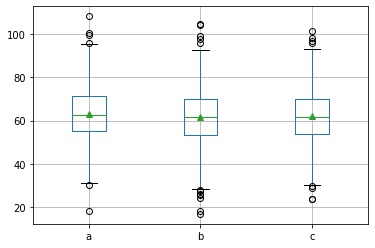

In [129]:
data.boxplot(showmeans = True)

In [121]:
# Напишем функцию для ANOVA
def anova(data):
    #Среднее по всему датасету
    grand_mean = np.mean(data.values)
    
    #Среднее по группам
    means_of_groups = np.mean(data, axis = 0)
    
    # Сохранияем количество строк и столбцов
    columns = data.shape[1]
    rows = data.shape[0]
    
    #Отклонения в пределах группы
    ssw = ((data - means_of_groups) ** 2).sum().sum()
    ssw_df = (rows - 1) * columns
    
    #Отклонения между группами
    ssb = (((means_of_groups - grand_mean) ** 2) * rows).sum()
    ssb_df = columns - 1
    
    # Считаем f статистику и p-value
    f_statistic = (ssb / ssb_df) / (ssw / ssw_df)
    p_value = 1 - st.f.cdf(f_statistic, ssb_df, ssw_df)
    
    return f_statistic, p_value 

In [122]:
anova(data)

(4.364713262172874, 0.012799246443552459)

In [123]:
# Проверка с помощью scipy
st.f_oneway(a, b, c)

F_onewayResult(statistic=4.364713262173519, pvalue=0.012799246443542096)

In [130]:
# Проверка с помощью непараметрического аналога kruskal-wallis. 
# Но тут сравниваются медианы: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html
st.kruskal(a, b, c)

KruskalResult(statistic=7.694906305896438, pvalue=0.02133400174577467)

## Post hoc анализ

С помощью ANOVA мы определили, что есть статистическая разница между группами, но как понять в какой группе есть отличия? 
Для этого существует Post-hoc анализ

В простейшом варианте мы используем парные t тесты, но с поправкой на множественное сравнение.

Откуда берется проблема множественных сравнений? Когда мы проводим несколько тестов на одних и тех же данных, то вероятность получить ложные результаты тестов возрастает. При одиночном сравнении, вероятность ошибки первого рода обычно равна 5-ти процентам. При множественном сравнении групповая ошибка будет равна:

P(вероятность хотя бы одной ошибки 1 рода) = 1 - P(веротность не совершить ошибку 1 рода)^c

где 
* с - число проведенных тестов
* P(веротность не совершить ошибку 1 рода) при alpha = 0.05 будет равным 0.95. 

Т.е.  мы считаем вероятность не совершить ошибку первого рода для всех сравнений. Для пары один и для пары два и так далее. А затем вычитаем полученное значение из единицы.

Для трех тестов при alpha = 0.05 , групповая ошибка будет такой:

P = 1 - (0.95)**3 = 0.14

Самая простая поправка на множетвенное сранение это поправка Бонферрони. Метод поправки Бонферрони утверждает, что для уменьшения ложноположительных результатов необходимо отклонить те гипотезы, для которых p-value < alpha/с, где с - число проведенных тестов.

Метод плох тем, что уменьшает мощность теста, т.е. повышается вероятность совершить ошибку второго рода.

In [136]:
# Создаем комбинации для парных тестов
groups_combinations = list(combinations(data.columns,2))
groups_combinations

[('a', 'b'), ('a', 'c'), ('b', 'c')]

In [156]:
# Применяем поправку Бонферрони
alpha = 0.05
bonferroni_alpha = alpha / len(groups_combinations)
bonferroni_alpha

0.016666666666666666

In [150]:
for group1, group2 in groups_combinations:
    test_result = st.ttest_ind(data[group1],data[group2])
    p_value = test_result[1]
    if p_value < bonferroni_alpha:
        print('Для пары: {} и {} отвергаем нулевую гипотезу, p-value равен {}'.format(group1, group2, p_value))
    else:
        print('Для пары: {} и {} не можем отвергнуть нулевую гипотезу, p-value равен {}'.format(group1, group2, p_value))

Для пары: a и b отвергаем нулевую гипотезу, p-value равен 0.006598959819563271
Для пары: a и c не можем отвергнуть нулевую гипотезу, p-value равен 0.018659901574186104
Для пары: b и c не можем отвергнуть нулевую гипотезу, p-value равен 0.6806223180621213


### Полезные ссылки:
* http://www.sevin.ru/dissertations/aspirantura/material/lecture-4-23.01.pdf
* https://habr.com/ru/post/304528/
* https://ru.wikipedia.org/wiki/Поправка_на_множественную_проверку_гипотез
* https://www.youtube.com/watch?v=pscJPuCwUG0